# Projekt 4: Generalna ocena jakości modeli przestrzennych RNA

In [1]:
# %pip install pandas biopython joblib scikit-learn catboost matplotlib

In [2]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from joblib import Parallel, delayed
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

1. Zapoznanie się z udostępnionymi zbiorami danych i ewentualne przetransformowanie ich do postaci ułatwiającej zastosowanie technik sztucznej inteligencji np. integracja danych składowych przechowywanych w różnych formatach z wykorzystaniem jednej spójnej reprezentacji.

In [3]:
DATASET_PATH = Path("./resources/datasets/RNA-Puzzles")

challenges = [f"pz{index:02}" for index in range(1, 11)]

In [4]:
def parse_motifs(challenges: list[str]) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for challenge in challenges:
        current_df = pd.read_csv(
            DATASET_PATH / f"{challenge}/filter-results.txt",
            sep="\t",
            header=None,
            names=[
                "filename",
                "number_of_segments",
                "number_of_residues",
                "nucleotide_ranges",
                "sequences",
            ],
        )
        current_df["challenge_number"] = challenge
        result_df = pd.concat([result_df, current_df])

    result_df = result_df[result_df["number_of_segments"] >= 3]
    return result_df.reset_index(drop=True)


motifs = parse_motifs(challenges)
motifs

,filename,number_of_segments,number_of_residues,nucleotide_ranges,sequences,challenge_number
0,1_solution_0_rpr_A_4_C,3,20,"A1-A8, B10-B16, B19-B23","CCGCCGCG, CAUGCCU, GGCGG",pz01
1,1_solution_0_rpr_A_5_C,3,23,"A1-A9, B8-B15, B18-B23","CCGCCGCGC, GCCAUGCC, UGGCGG",pz01
2,1_solution_0_rpr_A_6_G,3,24,"A2-A10, B7-B14, B17-B23","CGCCGCGCC, CGCCAUGC, GUGGCGG",pz01
3,1_solution_0_rpr_A_7_C,3,24,"A3-A11, B6-B13, B16-B22","GCCGCGCCA, GCGCCAUG, UGUGGCG",pz01
4,1_solution_0_rpr_A_8_G,3,24,"A4-A12, B5-B12, B15-B21","CCGCGCCAU, CGCGCCAU, CUGUGGC",pz01
...,...,...,...,...,...,...
673,10_0_solution_4LCK_rpr_B_55_C,3,32,"A48-A63, B16-B21, B50-B59","AGGAUAGUGAAAGCUA, UGGUAG, GGGUUCGAAU",pz10
674,10_0_solution_4LCK_rpr_B_56_G,3,38,"A48-A64, B15-B22, B49-B61","AGGAUAGUGAAAGCUAG, GUGGUAGA, CGGGUUCGAAUCC",pz10
675,10_0_solution_4LCK_rpr_B_57_A,4,42,"A49-A54, A58-A64, B14-B22, B44-B63","GGAUAG, AAGCUAG, AGUGGUAGA, GGUCGCGGGUUCGAAUCCCG",pz10
676,10_0_solution_4LCK_rpr_B_58_A,4,43,"A59-A63, B6-B11, B13-B23, B43-B63","AGCUA, AGUAGU, CAGUGGUAGAA, GGGUCGCGGGUUCGAAUCCCG",pz10


In [5]:
def parse_xml_file(file_path: Path) -> pd.DataFrame:
    tree = ET.parse(file_path)
    root = tree.getroot()
    return pd.DataFrame(
        [
            {
                "filename": child.find("description").find("filename").text,
                "score": child.find("score").text,
            }
            for child in root
        ]
    )


def parse_scores(motifs: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for index, row in motifs.iterrows():
        core_path = DATASET_PATH / f"{row['challenge_number']}"
        xml_path = core_path / f"{row['filename']}-rmsd.xml"

        if xml_path.exists():
            current_df = parse_xml_file(xml_path)
            current_df["solution_directory"] = row["filename"]
            current_df["dataset_files_path"] = core_path / (
                f"{row['filename']}/" + current_df["filename"].apply(lambda x: x[:-4])
            )
            result_df = pd.concat([result_df, current_df])
        else:
            motifs.drop(index, inplace=True)

    return result_df


scores = parse_scores(motifs)
scores

,filename,score,solution_directory,dataset_files_path
0,1_bujnicki_1_rpr.pdb,4.769,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
1,1_bujnicki_2_rpr.pdb,4.594,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
2,1_bujnicki_3_rpr.pdb,3.921,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
3,1_bujnicki_4_rpr.pdb,4.522,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
4,1_bujnicki_5_rpr.pdb,4.616,1_solution_0_rpr_A_4_C,resources/datasets/RNA-Puzzles/pz01/1_solution...
...,...,...,...,...
21,10_DING_5_rpr.pdb,4.516,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
22,10_DING_6_rpr.pdb,3.939,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
23,10_DING_7_rpr.pdb,4.639,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...
24,10_DING_8_rpr.pdb,5.66,10_0_solution_4LCK_rpr_B_59_U,resources/datasets/RNA-Puzzles/pz10/10_0_solut...


In [6]:
def parse_pdb_file(file_path: Path) -> pd.DataFrame:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("PDB_structure", f"{file_path}.pdb")

    pdb_data: list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    pdb_data.append(
                        {
                            "atom_id": atom.serial_number,
                            "atom_name": atom.name,
                            "residue_name": residue.resname,
                            "chain_id": chain.id,
                            "residue_number": residue.id[1],
                            "x": atom.coord[0],
                            "y": atom.coord[1],
                            "z": atom.coord[2],
                            "occupancy": atom.occupancy,
                            "temperature_factor": atom.bfactor,
                        }
                    )
    return pd.DataFrame(pdb_data)


def parse_tor_file(file_path: Path, keep_ids: bool = False) -> pd.DataFrame:
    result_df = pd.read_csv(f"{file_path}.tor", sep="\s+")
    return (
        result_df.drop(columns=["Chain", "ResNum", "Name", "iCode"])
        if not keep_ids
        else result_df.rename(
            columns={
                "Chain": "chain_id",
                "ResNum": "residue_number",
                "Name": "residue_name",
                "iCode": "icode",
            }
        )
    )

2. Krótkie zapoznanie się z dostępnymi przestrzeniami reprezentacji struktur 3D RNA (przestrzenie kartezjańska i kątów torsyjnych) i ich formatami zapisu. Wybór obiecującej przestrzeni na której będziecie Państwo bazować wraz z uzasadnieniem.

In [7]:
example_path = scores["dataset_files_path"].values[0]
example_pdb = parse_pdb_file(example_path)
example_pdb.head()

,atom_id,atom_name,residue_name,chain_id,residue_number,x,y,z,occupancy,temperature_factor
0,1,C1',C,A,1,-20.322001,-0.227,69.922997,1.0,0.0
1,2,C2,C,A,1,-19.306999,-1.206,71.968002,1.0,0.0
2,3,C2',C,A,1,-19.379999,0.818,69.327003,1.0,0.0
3,4,C3',C,A,1,-19.302999,0.409,67.860001,1.0,0.0
4,5,C4,C,A,1,-18.016001,-3.167,71.891998,1.0,0.0


In [8]:
example_tor = parse_tor_file(example_path, keep_ids=True)
example_tor.head()

,chain_id,residue_number,icode,residue_name,alpha,beta,gamma,delta,epsilon,zeta,chi
0,A,1,-,C,-,-176.137,59.054,81.122,-174.56,-80.489,-145.907
1,A,2,-,C,161.855,-159.318,166.249,89.951,-117.771,-80.79,-160.341
2,A,3,-,G,-73.596,158.659,64.143,82.278,-147.484,-77.638,-164.295
3,A,4,-,C,-75.485,171.898,62.668,83.346,-152.214,-73.751,-155.038
4,A,5,-,C,-78.552,172.551,62.180,81.483,-152.556,-73.703,-151.534


3. Określenie procentowych progów pozwalających podzielić dostępny zbiór danych na część treningową, walidacyjną i ewaluacyjną. Czy rozmiar dostępnego zbioru jest wystarczający? Czy należy go rozbudować? Jeśli tak to w jaki sposób?

In [9]:
# train-validation-test splits -> 70-15-15
VALID_TEST_SIZE: float = 0.15
TRAIN_SIZE: float = 1 - (2 * VALID_TEST_SIZE)

assert TRAIN_SIZE > 0 and VALID_TEST_SIZE > 0

4. Określenie sposobu reprezentacji wiedzy, którą dysponujemy (tzn. wektora cech). Czy stosowane będą techniki identyfikacji najistotniejszych cech? Jeśli tak to jakie?

In [10]:
def find_max_tor_lines(scores: pd.DataFrame) -> int:
    return scores["dataset_files_path"].apply(lambda x: len(parse_tor_file(x))).max()


max_tor_lines = find_max_tor_lines(scores)
max_tor_lines

61

In [11]:
REPRESENTATIONS_PATH = Path("./resources/datasets/representations")
TOR_DATASET_PATH = REPRESENTATIONS_PATH / "tor_dataset.csv"

NUMBER_OF_ANGLES = 7
FILL_FEATURES_TO = max_tor_lines * NUMBER_OF_ANGLES  # 61 * 7 = 427


def preprocess_tor_data(tor_data: pd.DataFrame, missing_value: int = 0) -> np.ndarray:
    tor_data = tor_data.replace("-", missing_value).astype(float)
    tor_data = tor_data.values.flatten()
    padding_needed = max(0, FILL_FEATURES_TO - len(tor_data))
    padded_tor_data = np.pad(
        tor_data, pad_width=(0, padding_needed), mode="constant", constant_values=missing_value
    )
    return padded_tor_data


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    def normalize_column(column: pd.Series) -> pd.Series:
        non_zero_values = column[column != 0]
        min_val = non_zero_values.min()
        max_val = non_zero_values.max()

        column[column != 0] = (
            2 * (non_zero_values - min_val) / (max_val - min_val) - 1 if max_val != min_val else 0
        )
        return column

    return df.apply(normalize_column, axis="columns")


def prepare_tor_dataset(scores: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()
    for _, row in scores.iterrows():
        tor_data = parse_tor_file(row["dataset_files_path"])
        preprocessed_tor_data = preprocess_tor_data(tor_data)

        current_df = pd.DataFrame(preprocessed_tor_data).T
        current_df["score"] = row["score"]
        result_df = pd.concat([result_df, current_df])

    score_copy = result_df["score"].copy()
    result_df = normalize_data(result_df.drop(columns=["score"]))
    result_df["score"] = score_copy
    return result_df


def parallel_processing(scores: pd.DataFrame) -> pd.DataFrame:
    cores = max(1, os.cpu_count() - 1)
    data_splits = np.array_split(scores, cores)
    fn = delayed(prepare_tor_dataset)
    results = Parallel(n_jobs=cores, verbose=10)(fn(data_split) for data_split in data_splits)
    return pd.concat(results)


def make_tor_dataset_csv(scores: pd.DataFrame) -> None:
    dataset = parallel_processing(scores)
    dataset.to_csv(TOR_DATASET_PATH, index=False)


if not TOR_DATASET_PATH.exists():
    make_tor_dataset_csv(scores)

In [12]:
tor_dataset = pd.read_csv(TOR_DATASET_PATH)
tor_dataset

,0,1,2,3,4,5,6,7,8,9,...,418,419,420,421,422,423,424,425,426,score
0,0.0,-0.978661,0.339637,0.463333,-0.969821,-0.442532,-0.809215,0.915860,-0.884387,0.940489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.769
1,0.0,0.925007,0.302262,0.458506,-0.919853,-0.430515,-0.901528,-0.367817,0.971242,0.248807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.594
2,0.0,0.969942,0.310983,0.444815,-0.804548,-0.577312,-0.902394,0.905048,-0.871336,0.939470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.921
3,0.0,-0.907328,0.252716,0.409614,0.987071,-0.394564,-0.753726,-0.340666,0.941621,0.283139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.522
4,0.0,0.960478,0.304328,0.482642,-0.788699,-0.441201,-0.924806,-0.395413,1.000000,0.318126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20951,0.0,0.921765,0.350060,0.465399,-0.833842,-0.343431,-0.887391,-0.499000,0.832146,0.583481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.516
20952,0.0,0.933915,0.485690,0.427908,-0.831433,-0.394316,-0.926236,-0.485149,0.825322,0.675647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.939
20953,0.0,0.904442,0.422146,0.510393,-0.825556,-0.387512,-0.887714,-0.412740,0.901270,0.289614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.639
20954,0.0,0.920129,0.353021,0.379568,-0.880728,-0.366675,-0.906016,-0.484275,0.908835,0.714776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.660


In [13]:
def preprocess_tor_dataset(dataset: pd.DataFrame) -> tuple[np.array, np.array]:
    X = dataset.drop(dataset.columns[-1], axis=1)
    y = dataset[dataset.columns[-1]]
    return np.array(X), np.array(y)


X, y = preprocess_tor_dataset(tor_dataset)
X.shape, y.shape

((20956, 427), (20956,))

In [14]:
RANDOM_STATE: int = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE
)

print(
    f"""
    Train size: {X_train.shape} [{X_train.shape[0] / X.shape[0] * 100:.2f}%]
    Valid size: {X_valid.shape} [{X_valid.shape[0] / X.shape[0] * 100:.2f}%]
    Test  size: {X_test.shape} [{X_test.shape[0] / X.shape[0] * 100:.2f}%]
    """
)


    Train size: (14669, 427) [70.00%]
    Valid size: (3143, 427) [15.00%]
    Test  size: (3144, 427) [15.00%]
    


5. Wybór obiecujących technik uczenia maszynowego, które uważacie Państwo, że powinny się sprawdzić podczas rozwiązywania postawionego problemu wraz z uzasadnieniem (np. głębokie sieci neuronowe, SVM, RandomForest ,itd.).

In [15]:
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor

common_params = {"random_state": RANDOM_STATE, "verbose": False}

param_grids = {
    # MLPRegressor best params: {'alpha': 0.01, 'hidden_layer_sizes': (1250,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001}
    # with RMSE score: 5.090
    "MLP": {
        "hidden_layer_sizes": [(750,), (1000,), (1250,), (1500,)],
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "learning_rate": ["invscaling", "adaptive"],
        "learning_rate_init": [0.001, 0.01, 0.1],
    },
    # CatBoostRegressor best params: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
    # with RMSE score: 4.187
    "CatBoost": {
        "learning_rate": [0.01, 0.03, 0.05],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5],
    },
}

regressors = {
    "MLP": MLPRegressor(
        hidden_layer_sizes=(1250,),
        alpha=0.01,
        learning_rate="invscaling",
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=VALID_TEST_SIZE,
        **common_params
    ),
    "CatBoost": CatBoostRegressor(
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=1,
        custom_metric="MAE",
        eval_metric="RMSE",
        early_stopping_rounds=8,
        **common_params
    ),
}

In [16]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


def find_best_params(Regressor, param_grid: dict) -> None:
    regr = GridSearchCV(Regressor, param_grid, scoring=rmse_scorer, n_jobs=-1, cv=3, verbose=3)

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    print(
        f"""
        {type(Regressor).__name__} best params: {regr.best_params_}
        with RMSE score: {root_mean_squared_error(y_test, y_pred):.3f}
        """
    )

In [17]:
# find_best_params(regressors["MLP"], param_grids["MLP"])

In [18]:
# find_best_params(regressors["CatBoost"], param_grids["CatBoost"])

6. Iteracyjne przeprowadzenie procesu uczenia, określenie wartości parametrów kluczowych dla tego procesu (np. zastosowana funkcja straty, learning rate, optimizer, itd.) i wskazanie czy natrafiliście Państwo na jakieś problemy podczas tego procesu np. przeuczenie i jak Państwo sobie z tymi problemami poradziliście o ile rzeczywiście wystąpiły?

7. Optymalizacja wartości hiperparametrów – czy warto je optymalizować w przypadku rozpatrywanego problemu? Jeśli tak to w jaki sposób?

8. Wybór i uzasadnienie zastosowanych miar oceny, przeprowadzenie procesu ewaluacji uzyskanego(ych) modelu(i), podsumowanie i analiza uzyskanych wyników.

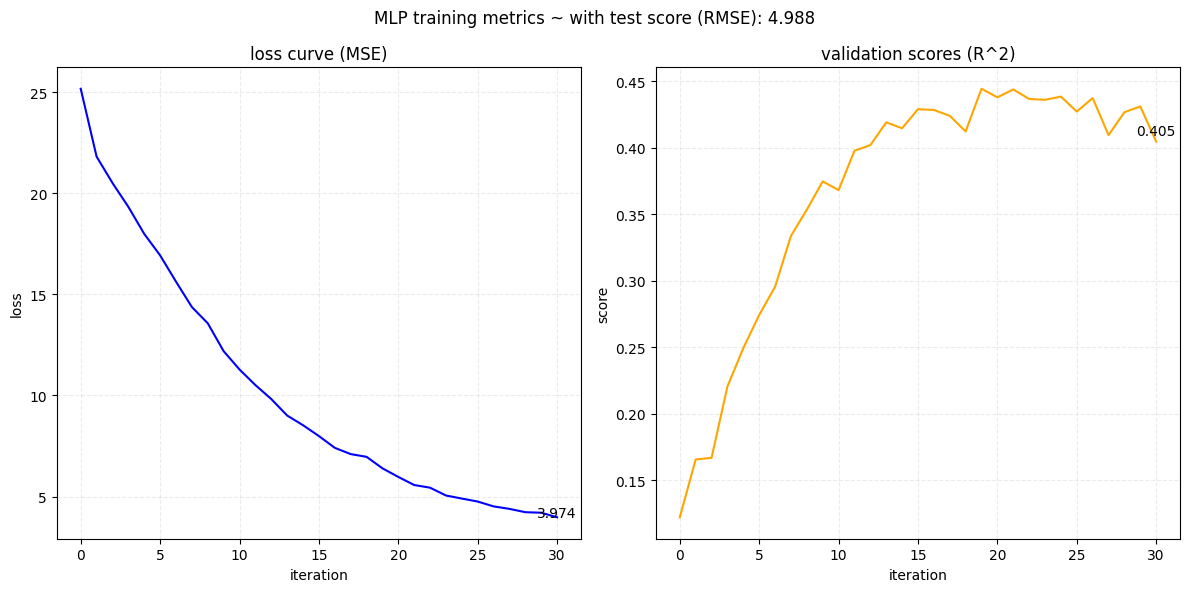

In [19]:
PLOTS_PATH = Path("./resources/figures")


def fit_and_predict_mlp(model: MLPRegressor, plot_metrics: bool = True) -> None:
    X_train_MLP = np.concatenate([X_train, X_valid])
    y_train_MLP = np.concatenate([y_train, y_valid])
    model.fit(X_train_MLP, y_train_MLP)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    if plot_metrics:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
        X_POS: int = len(model.loss_curve_) - 1
        Y_OFFSET: float = 0.005

        axs[0].plot(model.loss_curve_, color="blue")
        axs[0].text(
            x=X_POS,
            y=model.loss_curve_[-1] + Y_OFFSET,
            s=f"{model.loss_curve_[-1]:.3f}",
            ha="center",
        )
        axs[0].set_xlabel("iteration")
        axs[0].set_ylabel("loss")
        axs[0].set_title("loss curve (MSE)")
        axs[0].grid(linestyle="--", alpha=0.25)

        axs[1].plot(model.validation_scores_, color="orange")
        axs[1].text(
            x=X_POS,
            y=model.validation_scores_[-1] + Y_OFFSET,
            s=f"{model.validation_scores_[-1]:.3f}",
            ha="center",
        )
        axs[1].set_xlabel("iteration")
        axs[1].set_ylabel("score")
        axs[1].set_title("validation scores (R^2)")
        axs[1].grid(linestyle="--", alpha=0.25)

        fig.suptitle(f"MLP training metrics ~ with test score (RMSE): {rmse:.3f}")
        fig.savefig(PLOTS_PATH / "mlp_plot.png")


fit_and_predict_mlp(regressors["MLP"])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

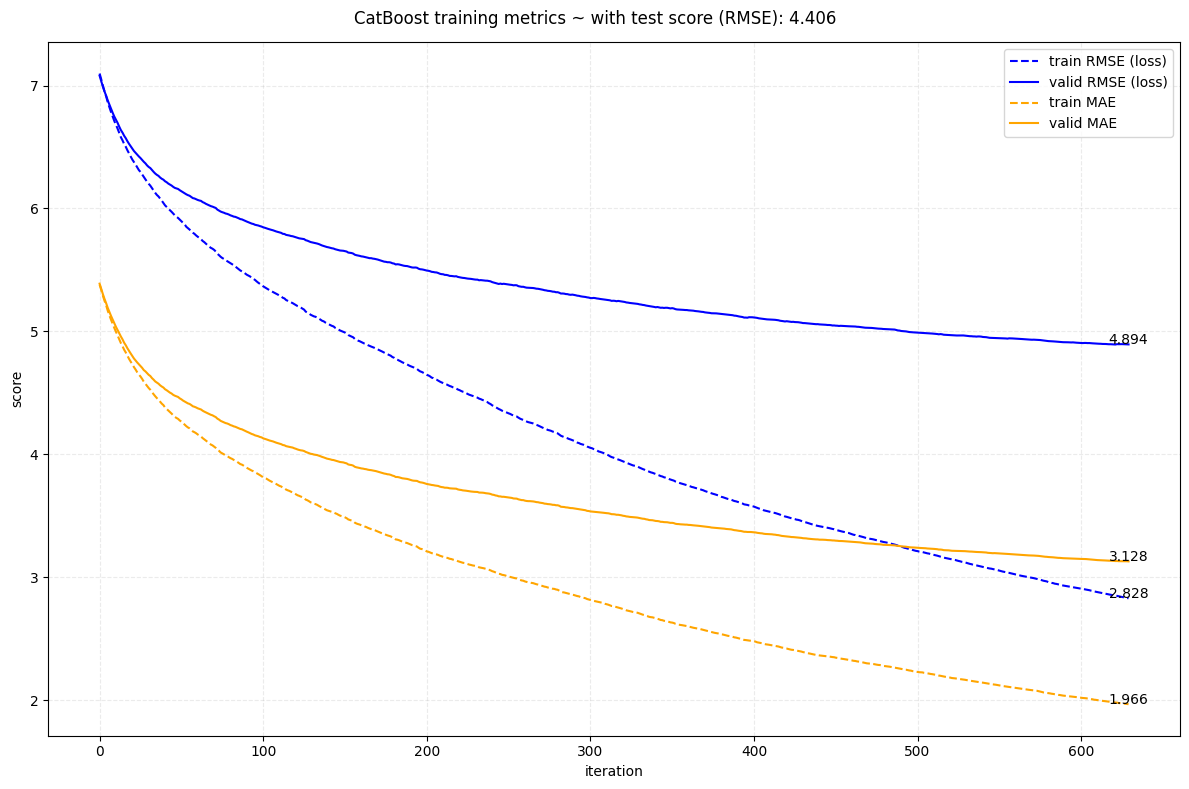

In [20]:
CATBOOST_INFO_PATH = Path("./catboost_info")


def read_catboost_info_file(filename: str) -> tuple[pd.Series, pd.DataFrame]:
    df = pd.read_csv(CATBOOST_INFO_PATH / f"{filename}_error.tsv", sep="\t")
    return df["iter"], df.drop(columns=["iter"])


def fit_and_predict_catboost(model: CatBoostRegressor, plot_metrics: bool = True) -> None:
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)

    if plot_metrics:
        train_iter, train_metrics = read_catboost_info_file("learn")
        valid_iter, valid_metrics = read_catboost_info_file("test")

        fig, axs = plt.subplots(1, 1, figsize=(12, 8), tight_layout=True)
        X_POS: int = len(train_iter) - 1
        Y_OFFSET: float = 0.005

        axs.plot(
            train_iter,
            train_metrics["RMSE"],
            label="train RMSE (loss)",
            color="blue",
            linestyle="--",
        )
        axs.text(
            x=X_POS,
            y=train_metrics["RMSE"].iloc[-1] + Y_OFFSET,
            s=f"{train_metrics['RMSE'].iloc[-1]:0.3f}",
            ha="center",
        )
        axs.plot(valid_iter, valid_metrics["RMSE"], label="valid RMSE (loss)", color="blue")
        axs.text(
            x=X_POS,
            y=valid_metrics["RMSE"].iloc[-1] + Y_OFFSET,
            s=f"{valid_metrics['RMSE'].iloc[-1]:0.3f}",
            ha="center",
        )

        axs.plot(
            train_iter, train_metrics["MAE"], label="train MAE", color="orange", linestyle="--"
        )
        axs.text(
            x=X_POS,
            y=train_metrics["MAE"].iloc[-1] + Y_OFFSET,
            s=f"{train_metrics['MAE'].iloc[-1]:0.3f}",
            ha="center",
        )
        axs.plot(valid_iter, valid_metrics["MAE"], label="valid MAE", color="orange")
        axs.text(
            x=X_POS,
            y=valid_metrics["MAE"].iloc[-1] + Y_OFFSET,
            s=f"{valid_metrics['MAE'].iloc[-1]:0.3f}",
            ha="center",
        )

        axs.set_xlabel("iteration")
        axs.set_ylabel("score")
        axs.grid(linestyle="--", alpha=0.25)
        axs.legend()

        fig.suptitle(f"CatBoost training metrics ~ with test score (RMSE): {rmse:.3f}")
        fig.savefig(PLOTS_PATH / "catboost_plot.png")


fit_and_predict_catboost(regressors["CatBoost"])